# Example - MultiModal CLIP Embeddings

# The Disappearing Embedding Function

Previously, to use vector databases, you had to do the embedding process yourself and interact with the system using vectors directly.
With this new release of LanceDB, we make it much more convenient so you don't need to worry about that at all.

1. We present you with sentence-transformer, openai, and openclip embedding functions that can be saved directly as table metadata
2. You no longer have to generate the vectors directly either during query time or ingestion time
3. The embedding function interface is extensible so you can create your own
4. The function is persisted as table metadata so you can use it across sessions

In [1]:
import lancedb

## Multi-modal search made easy

In this example we'll go over multi-modal image search using:
- Oxford Pet dataset
- OpenClip model
- LanceDB

### Data

First, download the dataset from https://www.robots.ox.ac.uk/~vgg/data/pets/
Specifically, download the [images.tar.gz](https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz)

This notebook assumes you've downloaded it into your ~/Downloads directory.
When you extract the tarball, it will create an `images` directory.

### Define embedding function

We'll use the OpenClipEmbeddingFunction here for multi-modal image search.

In [7]:
from lancedb.embeddings import EmbeddingFunctionRegistry

registry = EmbeddingFunctionRegistry.get_instance()
clip = registry.get("open-clip").create()

/home/saksham/Documents/lancedb/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
!pip install open_clip_torch

     |████████████████████████████████| 1.5 MB 771 kB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 21.0 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 43.1 MB/s eta 0:00:01
  Using cached protobuf-3.20.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
     |████████████████████████████████| 2.2 MB 28.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 39.9 MB/s eta 0:00:01
     |████████████████████████████████| 670.2 MB 47 kB/s s eta 0:00:01
     |████████████████████████████████| 53 kB 2.3 MB/s  eta 0:00:01
  Using cached Pillow-10.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.5 MB)
     |████████████████████████████████| 173 kB 22.0 MB/s eta 0:00:01
  Using cached filelock-3.12.4-py3-none-any.whl (11 kB)
     |████████████████████████████████| 1.3 MB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 89.2 MB 31.6 MB/s eta 0:00

In [8]:
clip

OpenClipEmbeddings(name='ViT-B-32', pretrained='laion2b_s34b_b79k', device='cpu', batch_size=64, normalize=True)

### The data model

We'll declare a new model that subclasses LanceModel (special pydantic model) to represent the table.
This table has two columns, one for the image_uri and one for the vector generated from those images.
The embedding function defines the number of dimensions in its vectors so you don't need to
look it up.

We use the `VectorField` method from the embedding function to annotate the model
so that LanceDB knows to use the open-clip embedding function to generate query embeddings that
correspond to the `vector` column.

We also use the `SourceField` so that when adding data, LanceDB knows to automatically use
open-clip to encode the input images.

Finally, because we're working with images, we add a convenience property `image` to open the image and
return a PIL Image so it can be visualized in Jupyter Notebook

In [ ]:
from PIL import Image
from lancedb.pydantic import LanceModel, Vector

class Pets(LanceModel):
    vector: Vector(clip.ndims) = clip.VectorField()
    image_uri: str = clip.SourceField()

    @property
    def image(self):
        return Image.open(self.image_uri)

### Create the table

First we connect to a local lancedb directory

In [ ]:
db = lancedb.connect("~/.lancedb")

Next we get all of the paths for the images we downloaded and create a table.
Notice that we didn't have to worry about generating the image embeddings ourselves.

In [ ]:
import pandas as pd
from pathlib import Path
from random import sample

if "pets" in db:
    table = db["pets"]
else:
    table = db.create_table("pets", schema=Pets)
    # use a sampling of 1000 images
    p = Path("~/Downloads/images").expanduser()
    uris = [str(f) for f in p.iterdir()]
    uris = sample(uris, 1000)
    table.add(pd.DataFrame({"image_uri": uris}))

In [ ]:
table.head().to_pandas()

,vector,image_uri
0,"[0.018789755, 0.11621179, -0.09760579, -0.0268...",/Users/changshe/Downloads/images/leonberger_14...
1,"[0.021960497, 0.06073219, -0.1625527, 0.021481...",/Users/changshe/Downloads/images/havanese_63.jpg
2,"[0.0074375155, 0.084355146, -0.027461205, -0.0...",/Users/changshe/Downloads/images/english_cocke...
3,"[-0.01220356, 0.020815236, -0.08587208, -0.027...",/Users/changshe/Downloads/images/shiba_inu_143...
4,"[-0.010112503, 0.14021927, -0.14588796, -0.046...",/Users/changshe/Downloads/images/saint_bernard...


### Querying via text

We also don't need to generate the embeddings when querying either.
LanceDB does that automatically so you can query directly using text input.

The pydantic model we declared for the table schema also makes it really easy for us to work with the search results

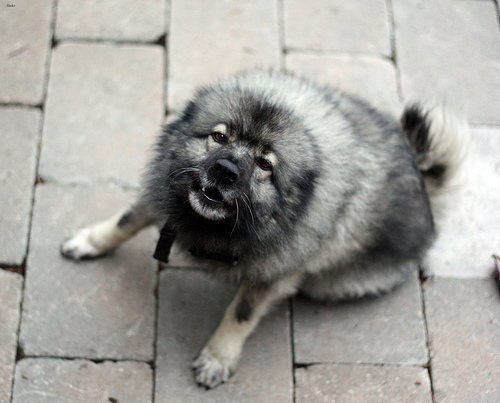

In [ ]:
rs = table.search("dog").limit(3).to_pydantic(Pets)
rs[0].image

### Querying via images

The great thing about CLIP is that it's multi-modal.
So you can search using not just text but images as well.

Create a query image using PIL

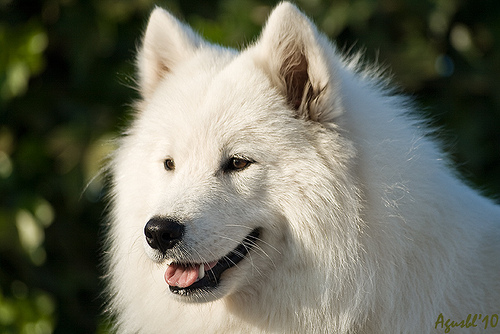

In [ ]:
from PIL import Image
p = Path("/Users/changshe/Downloads/images/samoyed_100.jpg")
query_image = Image.open(p)
query_image

Pass in the query_image to the search API

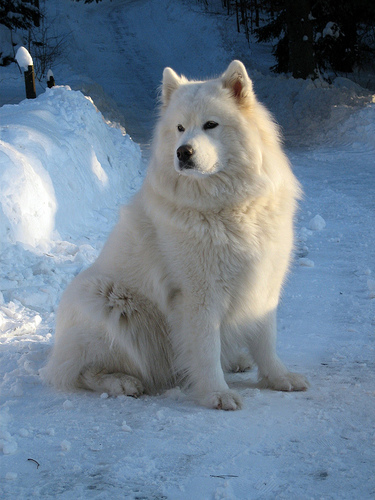

In [ ]:
rs = table.search(query_image).limit(3).to_pydantic(Pets)
rs[2].image

### Persistence

Embedding functions are persisted as table metadata so it's much easier to use across sessions.

For example we can recreate the database connection and table object

In [ ]:
db = lancedb.connect("~/.lancedb")
table = db["pets"]

We can observe that it's read out as table metadata

In [ ]:
import json

json.loads(table.schema.metadata[b"embedding_functions"])[0]

{'name': 'open-clip',
 'model': {'name': 'ViT-B-32',
  'pretrained': 'laion2b_s34b_b79k',
  'device': 'cpu',
  'batch_size': 64,
  'normalize': True},
 'source_column': 'image_uri',
 'vector_column': 'vector'}

And we can also run queries as before without having to reinstantiate the embedding function explicitly

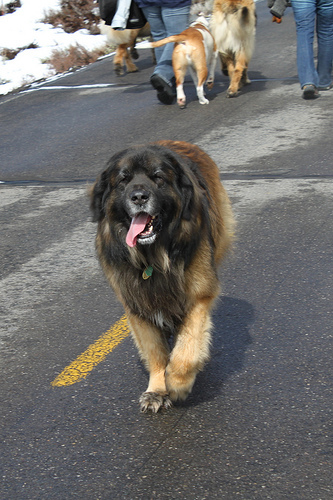

In [ ]:
rs = table.search("big dog").limit(3).to_pydantic(Pets)
rs[0].image

## LanceDB makes multimodal AI easy



- LanceDB's new embedding functions feature makes it easy for builders of LLM apps
- You no longer need to manually encode the data yourself
- You no longer need to figure out how many dimensions is your vector
- You no longer need to manually encode the query
- And with the right embedding model, you can search way more than just text